In [1]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `SH_CLIENT_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`, `SH_INSTANCE_ID`

The following additional environment variables have been loaded from `~/custom.env`:
* `AWS_BUCKET`
* `DAPA_URL`
* `DB_HOST`, `DB_NAME`, `DB_PASSWORD`, `DB_USER`
* `OGC_EDC_URL`
* `REFERENCE_DATA`


In [2]:
from edc import check_compatibility
check_compatibility("user-0.22.3")

# EDC Sentinel Hub: Data Fusion

## Example 2: Mapping crop NDVI with Sentinel-1 and Sentinel-2

[NDVI](https://www.sentinel-hub.com/eoproducts/ndvi-normalized-difference-vegetation-index) is a widely used vegetation index that uses Near Infra-Red (NIR) and Red wavelengths to measure the photosynthetic capacity of plant canopies. This index is a widely-used tool to assess agricultural crop conditions throughout the phenological cycle of the crops, linking chlorophyll activity to yield or canopy health [e.g. 1, 2].

[Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) is an ideal tool to monitor NDVI based on its NIR (B08, 842 nm) and Red bands (B04, 665 nm), owing to its large coverage, high spatial resolution (10/20 m), regular overpasses (~ 5 days) in comparison to other sensors. However, depending on the region and time of year, cloud cover can lead to sparse observations with the consequence of missing key stages of vegetation growth or activity. Furthermore, a 5-day revisit-time may not be sufficient to capture rapid changes in vegetation cover.

Studies have linked Synthetic Aperture Radar (SAR) backscattering data to vegetation development [e.g. 3, 4], and in particular to NDVI [5]. C-band SAR satellites such as [Sentinel-1](https://docs.sentinel-hub.com/api/latest/#/data/Sentinel-1-GRD) offer frequent (~ 6 days) high-resolution observations of the Earth's surface that have the advantage of being unaffected by cloud cover. 

In this Notebook, based on the relationship between radar backscatter and NDVI [5], we combine a Sentinel-2 L2A NDVI product partly occulted by clouds with Sentinel-1 GRD observation to produce a seamless NDVI product. 


<sub><sup>[1] _Quarmby et al., 1993, The use of multi-temporal NDVI measurements from AVHRR data for crop yield estimation and prediction, DOI: 10.1080/01431169308904332._</sup></sub>

<sub><sup>[2] _Mazzetto et al., 2010, Integration of optical and analogue sensors for monitoring canopy health and vigour in precision viticulture, DOI: 10.1007/s11119-010-9186-1._</sup></sub>

<sub><sup>[3] _Capodici et al., 2013, Investigating the Relationship between X-Band SAR Data from COSMO-SkyMed Satellite and NDVI for LAI Detection. DOI: 10.3390/rs5031389._</sup></sub>

<sub><sup>[4] _Inoue et al., 2014, Capability of C-band backscattering coefficients from high-resolution satellite SAR sensors to assess biophysical variables in paddy rice, DOI: 10.1016/j.rse.2013.09.001._</sup></sub>

<sub><sup>[5] _Filgueiras et al., 2019, Crop NDVI Monitoring Based on Sentinel 1, DOI: 10.3390/rs11121441._</sup></sub>

### Prerequisites

This notebook requires an active subscription to:

-   EDC Sentinel Hub

In [3]:
# Request tools imports
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

In [4]:
# Utilities
import shapely.geometry
import IPython.display

In [5]:
%matplotlib inline

### Setup

In [6]:
# Pass the Sentinel Hub Client ID and Secret to variables to be used in the request.
my_client_id = %env SH_CLIENT_ID
my_client_secret = %env SH_CLIENT_SECRET

In [7]:
# Create an OAuth2 session based on the client ID
client = BackendApplicationClient(client_id=my_client_id)
oauth = OAuth2Session(client=client)

The Sentinel Hub API uses OAuth2 Authentication and requires that you have an [access token](https://docs.sentinel-hub.com/api/latest/#/API/authentication). These tokens are limited in time, but a new one can be requested with the following command.

In [8]:
# Get a token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=my_client_id, client_secret=my_client_secret)

## Setting an area of interest

We will download Sentinel-1 and Sentinel-2 imagery over cropland located to the west of Dodge City, Kansas. The region is characterised by intensive agriculture, mainly wheat and sorghum cultivated in circular crop fields.

The bounding box is in the WGS84 coordinate system, and consists of the longitude and latitude coordinates of lower left and upper right corners.

In [9]:
# Set bounding box coordinates for the area of interest
bbox = (-100.9204, 37.5718, -100.4865, 37.8640)

In [10]:
# Display the coordinates on a map
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

## API request

We need to specify arguments to send a POST request, more information about all the availaible options [here](https://docs.sentinel-hub.com/api/latest/reference/#operation/process):

-   The access point URL:  set it to `https://services.sentinel-hub.com/api/v1/process`

-   `json` - the contents of the request containing:
	- `input`: (required) specifies the data to request:
		- `bounds`: defines the request bounds by specifying the bounding box and/or geometry for the request.
		- `data`: describes the data being requested along with certain processing and filtering parameters.
	- `output`: (optional) allows to set parameters for the returned data
		-  `width`: The request image width. Must be an integer between 1 and 2500. 
        -  `height`: The request image height. Must be an integer between 1 and 2500. 
	- `evalscript`: calculates the output values for each pixel


#### Step 1
First, set the input options. The options are set in the form of a dictionary with key/values pairs.

1. Specify the bounds of your request using the bounding box previously described and specifying the [projection]( 
https://docs.sentinel-hub.com/api/latest/#/API/crs?id=crs-support) (one of the CRS supported by Sentinel Hub API).

2. Specify the data to fetch. As in this example there are 2 data sources (Sentinel-1 and Sentinel-2), the options for each sensor are specified in a list of dictionaries.  

In [11]:
# 1. Bounds 
bounds = {"properties":{"crs":"http://www.opengis.net/def/crs/OGC/1.3/CRS84"}, "bbox": bbox}

# 2. Data
# Following Filgueiras et al. (2019), the Sentinel-1 orthorectified sigma_0 bands are returned.
# We also use Atmospherically corrected Sentinel-2 (L2A) data

data = [{"id": "s1", 
         "type": "S1GRD",
          "dataFilter": {"timeRange": {"from": "2019-04-26T00:00:00Z",
                                       "to": "2019-04-26T23:59:00Z"},
                         "mosaickingOrder": "mostRecent"},
         "processing": {
                    "orthorectify": "true",
                    "backCoeff": "SIGMA0_ELLIPSOID"
                }},
         {"id": "l2a",
          "type": "S2L2A",
          "dataFilter": {"timeRange": {"from": "2019-04-26T00:00:00Z",
                                       "to": "2019-04-26T23:59:00Z"},
                         "mosaickingOrder": "mostRecent"}}]
# Set the options to the input
input_options = {"bounds": bounds, "data": data,}

#### Step 2

Then set the output options. The default output size of the requested image is 256x256 pixels, so here we will modify the output to be larger. The result will be displayed only, therefore we also set the output format to jpeg.

In [12]:
output_options = {"width": 640, "height": 640, "responses": [{"format": {"type": "image/jpeg",
                                                                         "quality": 90}}]}

#### Step 3

The [evalscript](https://docs.sentinel-hub.com/api/latest/#/Evalscript/) is a piece of javascript code that allows to process the pixels of the images that are returned.

In the current example, the S1 and S2 bands needed are called in the `setup` function of the script. 

To compare the results of the fused NDVI product, several requests will be run with slightly different evalscripts. We will return:

1 - The S2 [True Color](https://www.sentinel-hub.com/eoproducts/true-color) visualisation (scaled by 2.5 for better viewing).

2 - The S2 NDVI visualisation.

3 - The merged S1-S2 NDVI visualisation. 

In [13]:
# 1. Evalscript returning the True Color Visualisation of S2 data
tc_evalscript = """
//VERSION=3
function setup (){
  return {
    input: [
      {datasource: "s1", bands:["VV", "VH"]},
      {datasource: "l2a", bands:["B02", "B03", "B08", "B04", "SCL"], units:"REFLECTANCE"}],
    output: [
      {id: "default", bands: 3, sampleType: SampleType.AUTO}
    ]
  }
}

function evaluatePixel(samples) {
  var s2 = samples.l2a[0]
  
  return {default: [s2.B04 * 2.5, s2.B03 * 2.5, s2.B02 * 2.5]}
  }
"""

In [14]:
# 2. Evalscript returning the S2 NDVI
s2_ndvi_evalscript = """
//VERSION=3
function setup (){
  return {
    input: [
      {datasource: "s1", bands:["VV", "VH"]},
      {datasource: "l2a", bands:["B02", "B03", "B08", "B04", "SCL"], units:"REFLECTANCE"}],
    output: [
      {id: "default", bands: 3, sampleType: SampleType.AUTO}
    ]
  }
}

function evaluatePixel(samples) {
    
  var s2 = samples.l2a[0]

  // Create an NDVI visualiser
  var viz=new ColorMapVisualizer([[0.0,0xa50026],
                                  [0.0,0xd73027], [0.2,0xf46d43],
                                  [0.3,0xfdae61], [0.4,0xfee08b],
                                  [0.5,0xffffbf], [0.6,0xd9ef8b],
                                  [0.7,0xa6d96a], [0.8,0x66bd63],
                                  [0.9,0x1a9850], [1.0,0x006837]]);
  // Calculate S2 NDVI
  let ndvi = index(s2.B08, s2.B04)

  return {default: viz.process(ndvi)}
}
"""

In [15]:
s12_ndvi_evalscript = """
//VERSION=3
function setup (){
  return {
    input: [
      {datasource: "s1", bands:["VV", "VH"]},
      {datasource: "l2a", bands:["B02", "B03", "B08", "B04", "SCL"], units:"REFLECTANCE"}],
    output: [
      {id: "default", bands: 3, sampleType: SampleType.AUTO}
    ]
  }
}

function toDb(linear) {
  // Convert the linear backscatter to DB (Filgueiras et al. (2019), eq. 3)
  return 10 * Math.LN10 * linear
}

function calc_s1_ndvi(sigmaVV, sigmaVH){
    // Convert sigma0 to Decibels
    let vh_Db = toDb(sigmaVH)
    let vv_Db = toDb(sigmaVV)

    // Calculate NRPB (Filgueiras et al. (2019), eq. 4)
    let NRPB = (vh_Db - vv_Db) / (vh_Db + vv_Db)

    // Calculate NDVI_nc with approach A3 (Filgueiras et al. (2019), eq. 14)
    let NDVInc = 2.572 - 0.05047 * vh_Db + 0.176 * vv_Db + 3.422 * NRPB

    return NDVInc
}

function evaluatePixel(samples) {
  var s1 = samples.s1[0]
  var s2 = samples.l2a[0]

  // Create an NDVI visualiser
  var viz=new ColorMapVisualizer([[0.0,0xa50026],
                                  [0.0,0xd73027], [0.2,0xf46d43],
                                  [0.3,0xfdae61], [0.4,0xfee08b],
                                  [0.5,0xffffbf], [0.6,0xd9ef8b],
                                  [0.7,0xa6d96a], [0.8,0x66bd63],
                                  [0.9,0x1a9850], [1.0,0x006837]]);
  // Calculate S2 NDVI
  let ndvi = index(s2.B08, s2.B04)
  // Calculate S1 NDVI
  let s1_ndvi = calc_s1_ndvi(s1.VV, s1.VH)
  
  // Use the S2-L2A classification to identify clouds
  if ([7, 8, 9, 10].includes(s2.SCL)) {
    // If clouds are present use S1 NDVI
    return {
      default: viz.process(s1_ndvi)
    }
  } else {
    // Otherwise use s2 NDVI
    return {
      default: viz.process(ndvi)
    }
  }
}
"""

#### Step 4 (final)

The different parts of the request built above are merged together in the `oauth.post` command and the request is posted. If all the elements are correct, the command should return a `200` status.

In [16]:
# Here we call the first evalscript for a True Color visualisation of Sentinel-2. 
response_tc = oauth.post('https://services.sentinel-hub.com/api/v1/process',
  json={"input": input_options,
        "evalscript": tc_evalscript,
        "output": output_options,
})

print("Request status: %s, %s" % (response_tc.status_code, response_tc.reason))

Request status: 200, OK


In [17]:
# Here we call the first evalscript for the Sentinel-2 NDVI visualisation. 
response_s2_ndvi = oauth.post('https://services.sentinel-hub.com/api/v1/process',
  json={"input": input_options,
        "evalscript": s2_ndvi_evalscript,
        "output": output_options,
})

print("Request status: %s, %s" % (response_s2_ndvi.status_code, response_s2_ndvi.reason))

Request status: 200, OK


In [18]:
# Here we call the first evalscript for the Sentinel-2 NDVI visualisation. 
response_s12_ndvi = oauth.post('https://services.sentinel-hub.com/api/v1/process',
  json={"input": input_options,
        "evalscript": s12_ndvi_evalscript,
        "output": output_options,
})

print("Request status: %s, %s" % (response_s12_ndvi.status_code, response_s12_ndvi.reason))

Request status: 200, OK


## Results

Below, the True Color visualisation of the Sentinel-2 image shows the circular crop fields forming the agricultural landscape near Dodge City. The brown colored fields are most likely bare soil (i.e. the crops haven't yet emerged) given the date of the acquisition (26-04-2019). A certain number of fields appear to have crops growing (they appear green in the image). Part of the image is occulted by dense cloud cover.

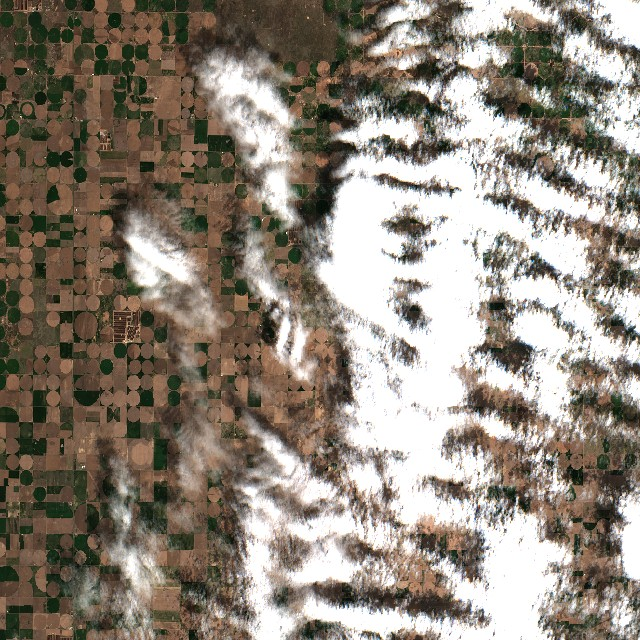

In [19]:
IPython.display.Image(response_tc.content)

Below, the Sentinel-2 NDVI product clearly highlights the fields in which crop are present (green) with varying NDVI values (represented in different shades of green, the darker the green, the higher the NDVI value). The agricultural plots where no crops are growing are shown in red in the image (NDVI < 0). However, the right part of the image is mostly cloud covered, which is clearly visible in the NDVI product. 

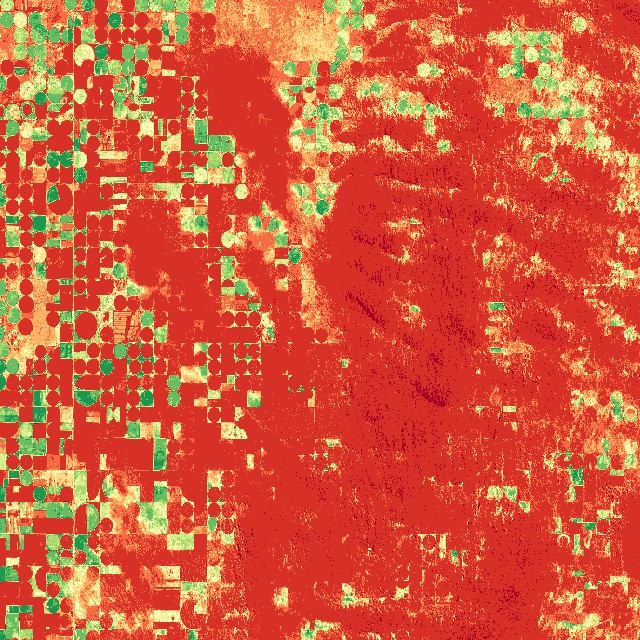

In [20]:
IPython.display.Image(response_s2_ndvi.content)

In the image below, the Sentinel-2 NDVI values located in cloud-covered areas were replaced with NDVI calculated from the Sentinel-1 data. The fusion of the two data sources now allows showing the NDVI for the areas that were not resolved simply using Sentinel-2 data. A number of large fields, where crops are growing are now visible in the right part of the image. 

A few caveats remain nevertheless:

-  The image is quite noisy: the noise could be removed by speckle filtering. However, Sentinel Hub only allows a pixel-per-pixel approach at the moment, and therefore filtering windows cannot be applied.

-  The method developed by Filgueiras et al. (2019) is tied to the type of crop that it was calibrated for (soybean and maize). In the example shown here, the fields are mostly sorghum and wheat, thus leading to a bias in the absolute values of NDVI. This can be observed in the product, as the crops appear to have higher NDVI values in the parts of the image calculated with Sentinel-1. Applying this method to accurately analyse the NDVI in this image would require additional steps (regression over a cloud-free zone), but is out of the scope of this Notebook, whose purpose is to show the potential of data-fusion with Sentinel Hub.

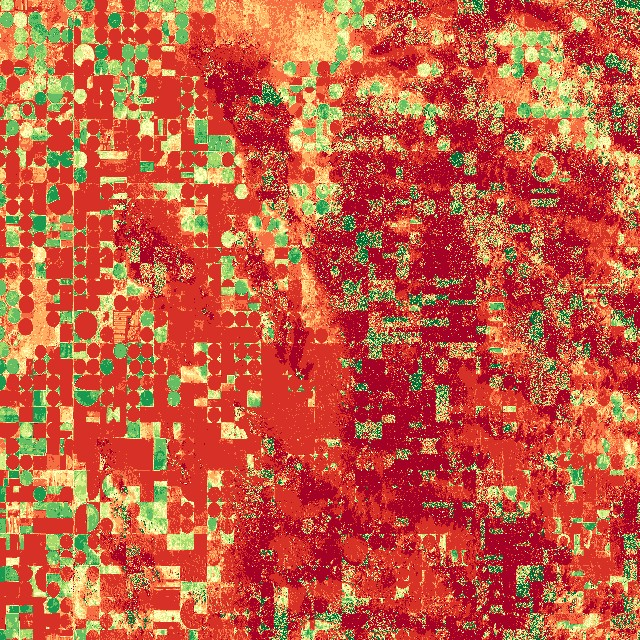

In [21]:
IPython.display.Image(response_s12_ndvi.content)